In [67]:
import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt

matplotlib.rcParams['font.sans-serif'] = ['FangSong'] #指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False #解决保存图像是负号‘-’显示为方块的问题

# 框架
* 引入、整理数据
* 校验数据是否合格
* GM(1,1)建模
* 将最新的预测数据当做真实值继续预测
* 输出结果

In [68]:
f = open('电影票房.csv')
df = pd.read_csv(f)
df.tail()


,years,money
6,2013,217.69
7,2014,296.39
8,2015,440.69
9,2016,457.12
10,2017,559.11


In [69]:
import pandas as pd
class GrayForecast():
    def __init__(self, data, datacolumn=None):
        if isinstance(data,pd.core.frame.DataFrame):
            self.data=data
            try:
                self.data.columns = ['数据']
            except:
                if not datacolumn:
                    raise Exception('您传入的dataframe不止一列')
                else:
                    self.data = pd.DataFrame(data[datacolumn])
                    self.data.columns=['数据']
        elif isinstance(data, pd.core.series.Series):
            self.data = pd.DataFrame(data, columns=['数据'])
        else:
            self.data = pd.DataFrame(data, columns=['数据'])

        self.forecast_list = self.data.copy()

        if datacolumn:
            self.datacolumn = datacolumn
        else:
            self.datacolumn = None
        #save arg:
        #        data                DataFrame    数据
        #        forecast_list       DataFrame    预测序列
        #        datacolumn          string       数据的含义
    def level_check(self):
        # 数据级比校验
        n = len(self.data)
        lambda_k = np.zeros(n-1)
        for i in range(n-1):
            lambda_k[i] = self.data.ix[i]["数据"]/self.data.ix[i+1]["数据"]
            if lambda_k[i] < np.exp(-2/(n+1)) or lambda_k[i] > np.exp(2/(n+2)):
                flag = False
        else:
            flag = True

        self.lambda_k = lambda_k

        if not flag:
            print("级比校验失败，请对X(0)做平移变换")
            return False
        else:
            print("级比校验成功，请继续")
            return True

        #save arg:
        #        lambda_k            1-d list
    def GM_11_build_model(self, forecast=5):
        if forecast > len(self.data):
            raise Exception('您的数据行不够')
        X_0 = np.array(self.forecast_list['数据'].tail(forecast))
    #       1-AGO
        X_1 = np.zeros(X_0.shape)
        for i in range(X_0.shape[0]):
            X_1[i] = np.sum(X_0[0:i+1])
    #       紧邻均值生成序列
        Z_1 = np.zeros(X_1.shape[0]-1)
        for i in range(1, X_1.shape[0]):
            Z_1[i-1] = -0.5*(X_1[i]+X_1[i-1])

        B = np.append(np.array(np.mat(Z_1).T), np.ones(Z_1.shape).reshape((Z_1.shape[0], 1)), axis=1)
        Yn = X_0[1:].reshape((X_0[1:].shape[0], 1))

        B = np.mat(B)
        Yn = np.mat(Yn)
        a_ = (B.T*B)**-1 * B.T * Yn

        a, b = np.array(a_.T)[0]

        X_ = np.zeros(X_0.shape[0])
        def f(k):
            return (X_0[0]-b/a)*(1-np.exp(a))*np.exp(-a*(k))

        self.forecast_list.loc[len(self.forecast_list)] = f(X_.shape[0])
    def forecast(self, time=5, forecast_data_len=5):
        for i in range(time):
            self.GM_11_build_model(forecast=forecast_data_len)
    
    def log(self):
        res = self.forecast_list.copy()
        if self.datacolumn:
            res.columns = [self.datacolumn]
        return res
    def reset(self):
        self.forecast_list = self.data.copy()
    def plot(self):
        self.forecast_list.plot()
        if self.datacolumn:
            plt.ylabel(self.datacolumn)
            plt.legend([self.datacolumn])

AttributeError: module 'matplotlib' has no attribute 'ylabel'

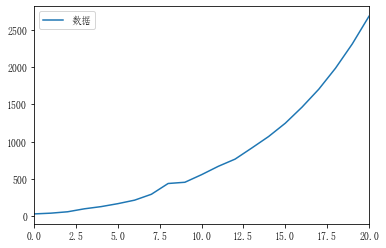

In [66]:
import pandas as pd
grayforecast = GrayForecast(df,'money')
grayforecast.forecast(10)
grayforecast.log()
grayforecast.plot()